In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('german.data-numeric', header = None, sep='\s+')
#or: pd.read_csv('german.data-numeric', header = None, delim_whitespace=True)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
0     1000 non-null int64
1     1000 non-null int64
2     1000 non-null int64
3     1000 non-null int64
4     1000 non-null int64
5     1000 non-null int64
6     1000 non-null int64
7     1000 non-null int64
8     1000 non-null int64
9     1000 non-null int64
10    1000 non-null int64
11    1000 non-null int64
12    1000 non-null int64
13    1000 non-null int64
14    1000 non-null int64
15    1000 non-null int64
16    1000 non-null int64
17    1000 non-null int64
18    1000 non-null int64
19    1000 non-null int64
20    1000 non-null int64
21    1000 non-null int64
22    1000 non-null int64
23    1000 non-null int64
24    1000 non-null int64
dtypes: int64(25)
memory usage: 195.4 KB


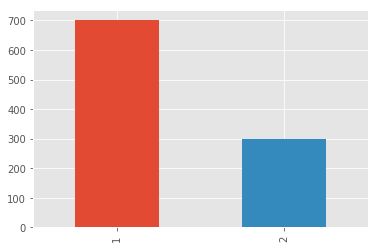

In [5]:
df[24].value_counts().plot.bar()

In [6]:
X = df.iloc[:, :-1]
Y = np.where(df[24] == 2, -1, 1)

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X.astype(float))

In [8]:
# Add a column of ones
X = np.c_[np.ones((X.shape[0])), X]

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def log_likelihood(X, Y, beta):
    Y_prime = np.where(Y == 1, 1, 0)
    proba = sigmoid(X.dot(beta))
    return Y_prime.dot(np.log(proba)) + (1 - Y_prime).dot(np.log(1 - proba))

In [10]:
def adapt_S(S, beta, sd, epsilon):
    t = len(beta)
    d = beta.shape[1]
    beta_prev = beta[:(t - 1)]
    beta_prev_bar = np.mean(beta_prev, axis = 0)
    beta_bar = np.mean(beta, axis = 0)    
    S_new = (t - 1)*S/t + sd/t*(t*np.dot(beta_prev_bar.T, beta_prev_bar) - (t + 1)*np.dot(beta_bar.T, beta_bar) 
                                + np.dot(beta[-1].reshape(-1, 1), beta[-1].reshape(1, -1)) + epsilon*np.eye(d))
    return S_new

In [11]:
def Cholesky(A):
    U, S, V = np.linalg.svd(A)
    L = U.dot(np.diag(np.sqrt(S)))
    return L
def robust_S(S, u, current, n, target = 0.234, gamma = 2/3):
    d = S.shape[0]
    A = np.eye(d) + min(1, d*n**(-gamma))*(current - target)*(u.reshape(-1, 1).dot(u.reshape(1, -1)))/(u.dot(u))
    S_new = Cholesky((S.dot(A)).dot(S.T))
    return S_new

In [12]:
def RW_Metropolis(X, Y, beta_init, S, iterations, n_burnin, t0 = 1, epsilon = 0.003, adapt = False, robust = False):
    p = len(beta_init)
    beta = np.zeros((iterations, p))
    accept = np.zeros(iterations)
    posterior = log_likelihood(X, Y, beta_init[:-1])
    beta[0] = beta_init
    
    for i in range(1, iterations):
        u = np.random.randn(p)
        beta_prop = beta[i - 1] + S.dot(u)
        if beta_prop[-1] > 0:
            posterior_prop = log_likelihood(X, Y, beta_prop[:-1])
            acceptance_prob = min(1, np.exp(posterior_prop - posterior))
            if acceptance_prob > np.squeeze(np.random.rand(1)):
                accept[i] = 1
                beta[i] = beta_prop
                posterior = posterior_prop
            else:
                beta[i] = beta[i - 1]
        else:
            beta[i] = beta[i - 1]
            acceptance_prob = 0
        
        if adapt & (i < n_burnin) & (i > t0):
            S = adapt_S(S, beta[:(i + 1)], (2.4)**2/p, epsilon)
        
        if robust & (i < n_burnin):
            S = robust_S(S, u, acceptance_prob, i, target = 0.234, gamma = 2/3)
            
    results = {'beta': beta[n_burnin:], 'S': S, 'acceptance_rate': np.sum(accept[n_burnin:]) / (iterations - n_burnin)}
    return results

In [13]:
beta_init = np.random.randn(X.shape[1] + 1)/X.shape[1]
S = 0.02*np.eye(X.shape[1] + 1)

## 1. Comparer les performances des deux algorithmes suivants

### a) random walk Metropolis

In [14]:
mcmc = RW_Metropolis(X, Y, beta_init, S, 10000, 5000, adapt = False, robust = False)

In [15]:
mcmc['acceptance_rate']

0.5466

In [16]:
mcmc['beta']

array([[ 1.1444565 ,  0.78848719, -0.23229821, ..., -0.20247972,
        -0.0988884 ,  0.50937526],
       [ 1.13364899,  0.78610973, -0.21932668, ..., -0.22650852,
        -0.11106985,  0.50314763],
       [ 1.13364899,  0.78610973, -0.21932668, ..., -0.22650852,
        -0.11106985,  0.50314763],
       ...,
       [ 1.23705331,  0.77779659, -0.51023063, ...,  0.07906516,
         0.02457575,  1.04391277],
       [ 1.23705331,  0.77779659, -0.51023063, ...,  0.07906516,
         0.02457575,  1.04391277],
       [ 1.20158631,  0.76891844, -0.48921416, ...,  0.09063985,
         0.02446798,  1.02181246]])

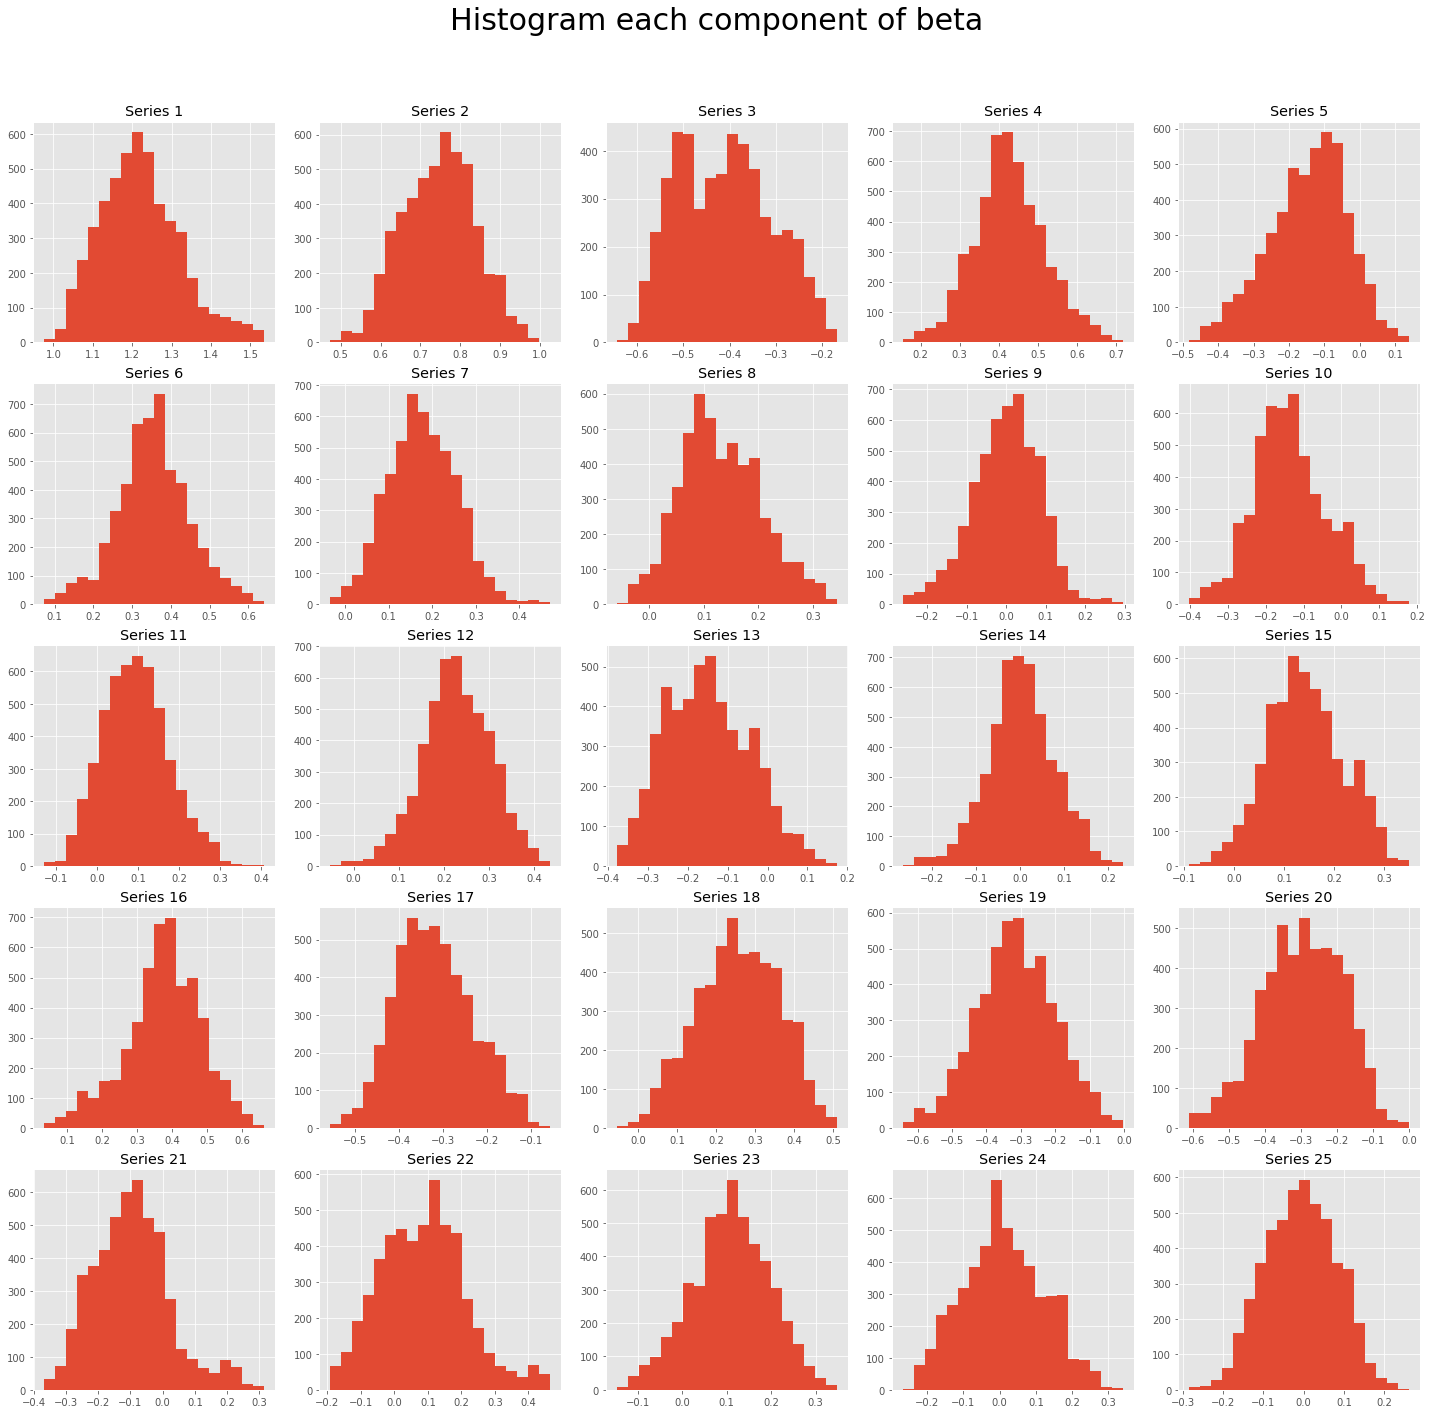

In [17]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    ax[i].hist(mcmc['beta'][:, i], bins = 20)
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('Histogram each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

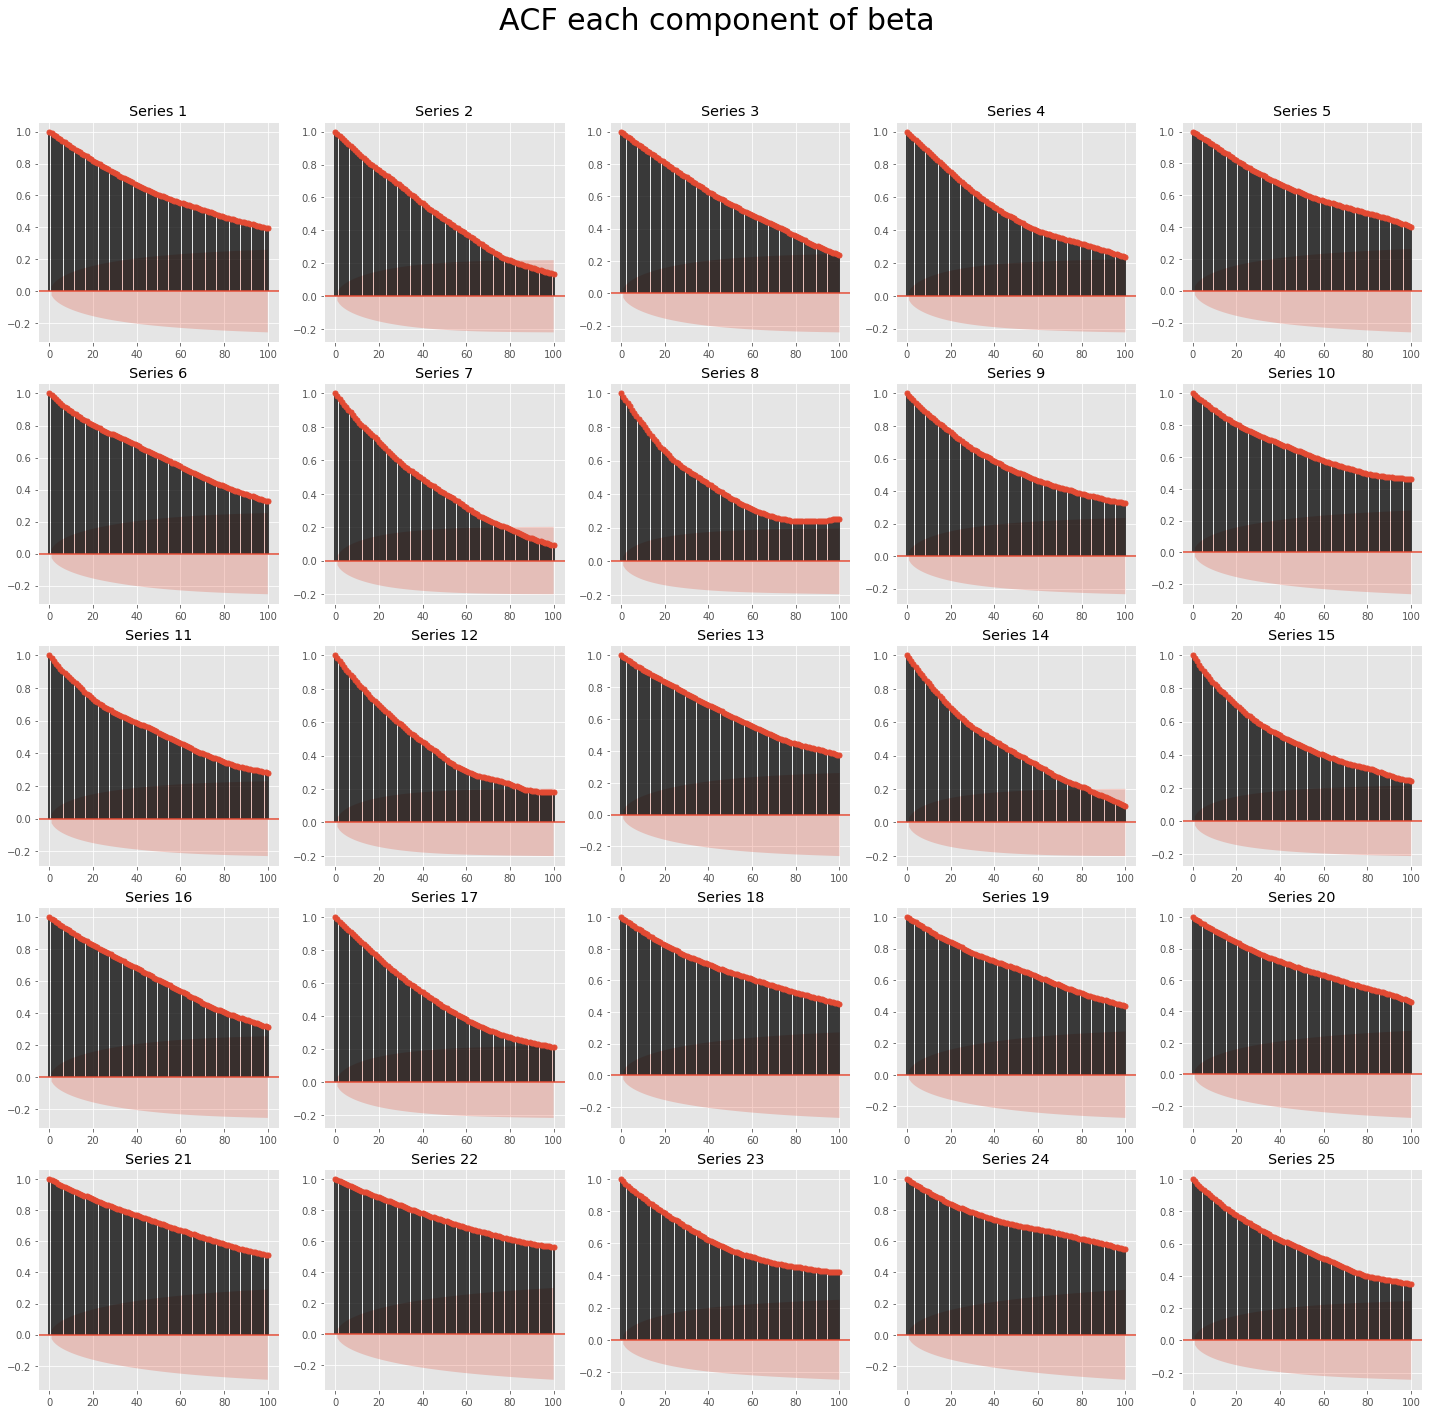

In [69]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    plot_acf(mcmc['beta'][:, i], lags = 100, ax = ax[i])
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('ACF each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [70]:
likelihood_hist = log_likelihood(X, Y, mcmc['beta'][:, :-1].T)

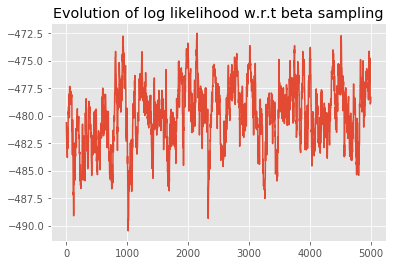

In [72]:
plt.plot(likelihood_hist)
plt.title('Evolution of log likelihood w.r.t beta sampling')
plt.savefig('LLH1.png')
plt.show()


In [26]:
beta_opt = mcmc['beta'][np.argmax(likelihood_hist), :-1]

In [31]:
Y_pred = np.where(sigmoid(X.dot(beta_opt)) > 0.5, 1, -1)

In [34]:
# Accuracy
len(np.where(Y == Y_pred)[0])*100/len(Y)

78.4

### b) Adaptive Metropolis

In [35]:
mcmc_adapt = RW_Metropolis(X, Y, beta_init, S, 10000, 5000, t0 = 1, epsilon = 0.0003, adapt = True, robust = False)

In [36]:
mcmc_adapt['acceptance_rate']

0.0684

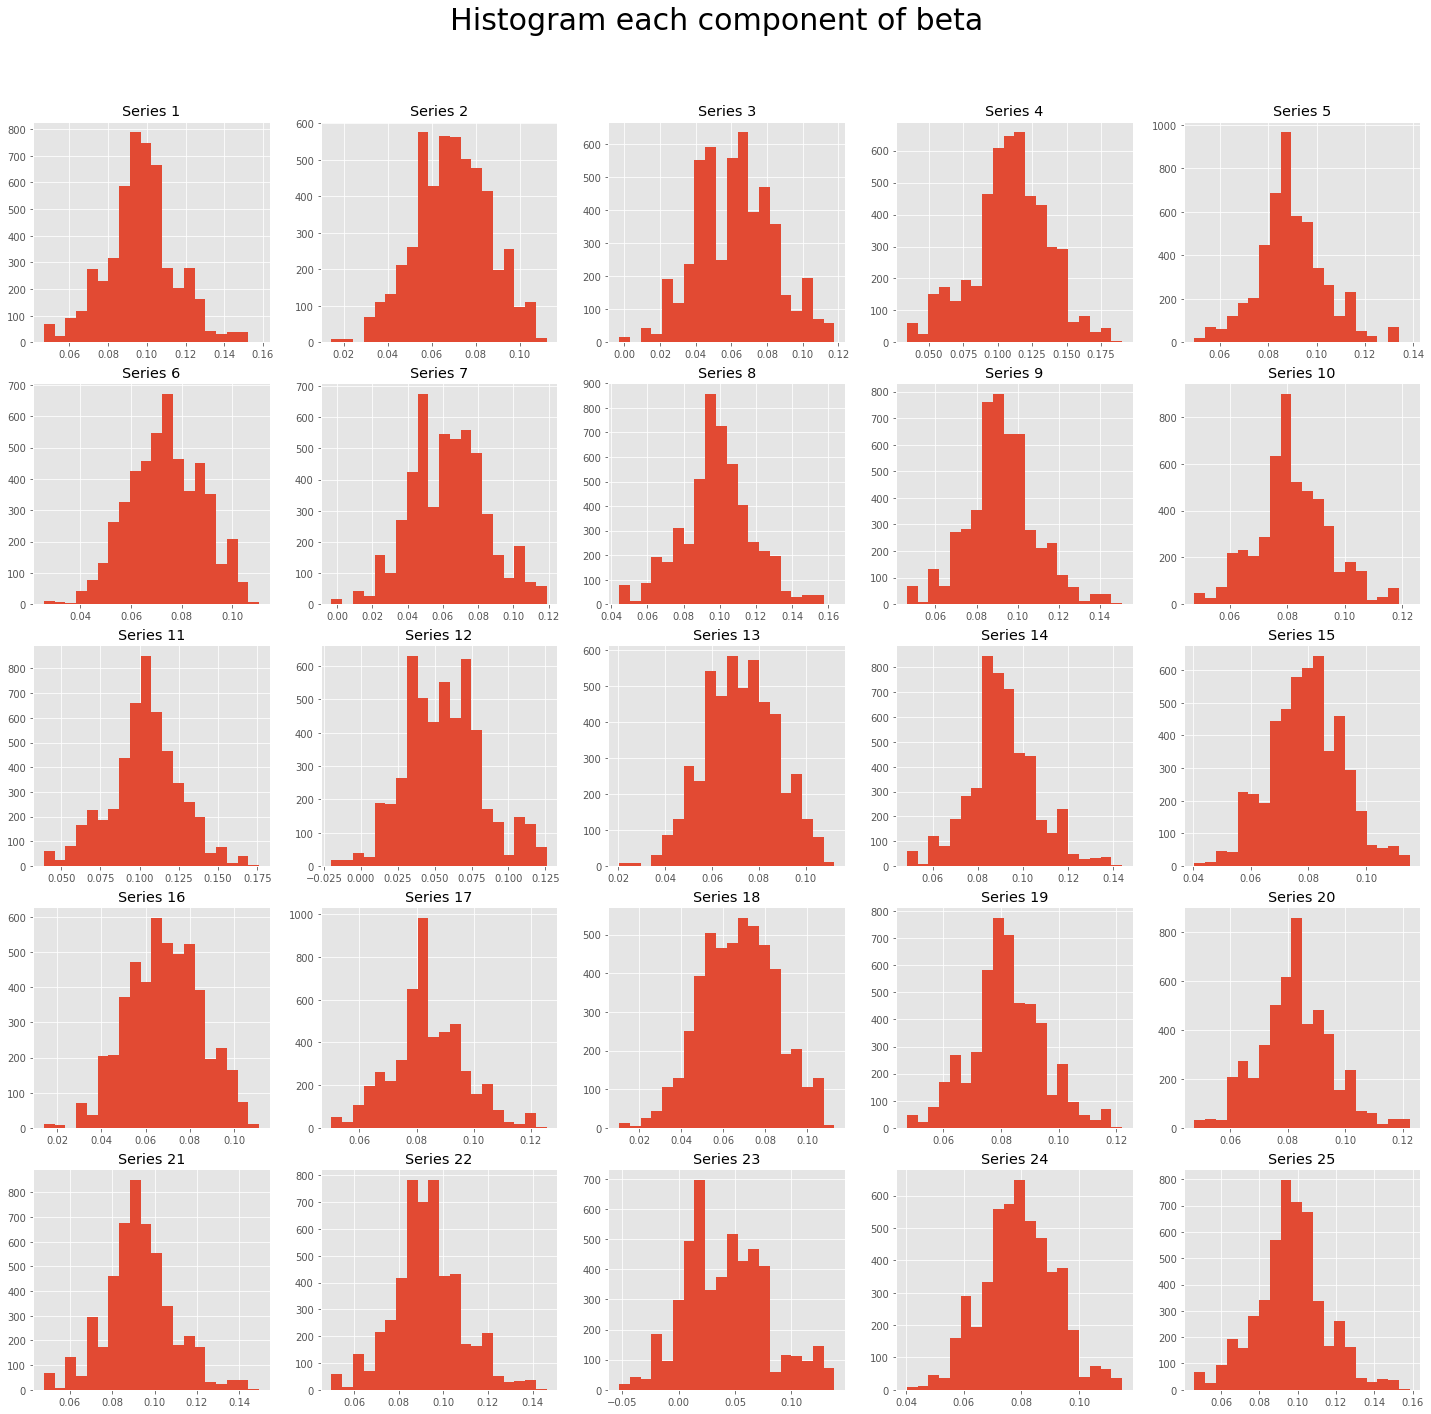

In [37]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    ax[i].hist(mcmc_adapt['beta'][:, i], bins = 20)
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('Histogram each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

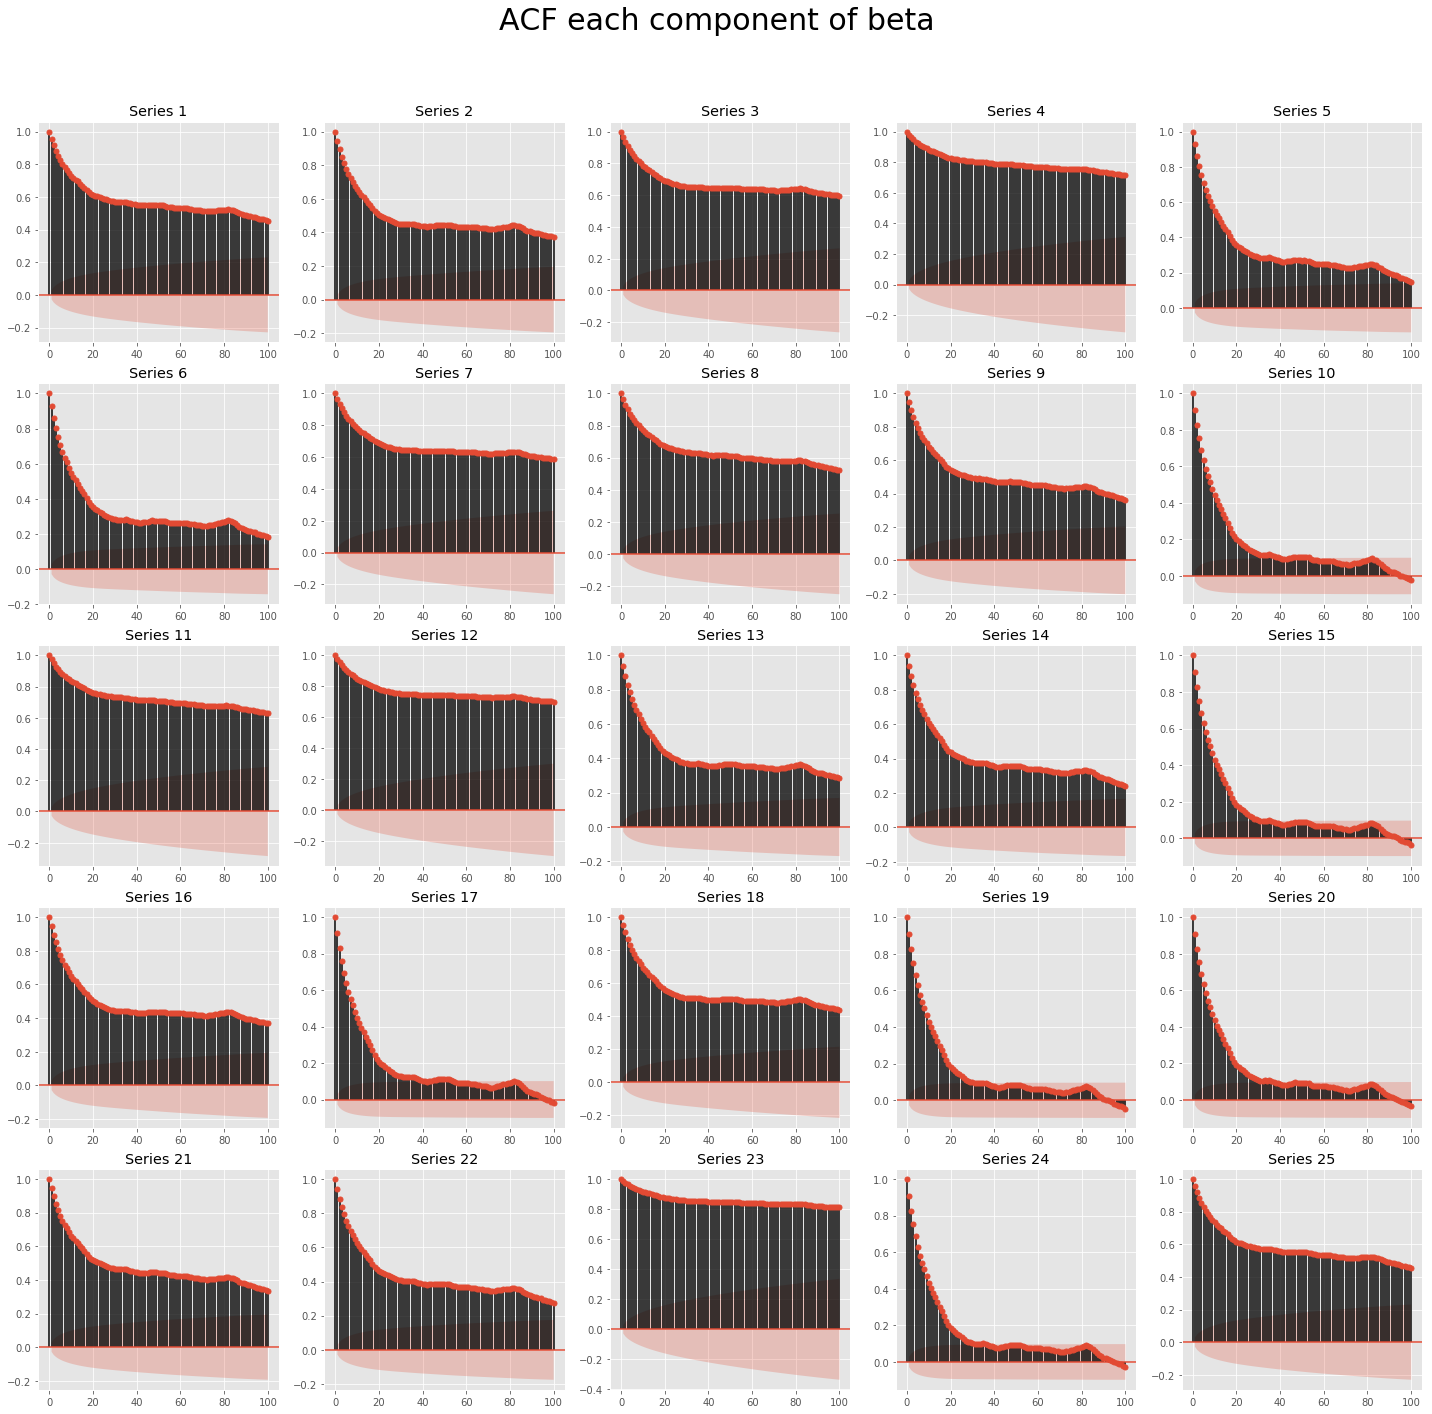

In [73]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    plot_acf(mcmc_adapt['beta'][:, i], lags = 100, ax = ax[i])
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('ACF each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [74]:
likelihood_hist = log_likelihood(X, Y, mcmc_adapt['beta'][:, :-1].T)

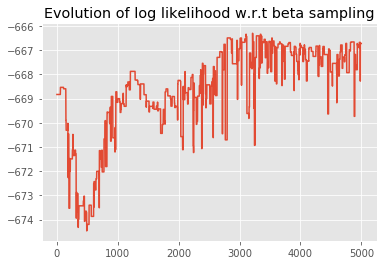

In [75]:
plt.plot(likelihood_hist)
plt.title('Evolution of log likelihood w.r.t beta sampling')
plt.savefig('LLH2.png')
plt.show()

In [43]:
beta_opt = mcmc_adapt['beta'][np.argmax(likelihood_hist), :-1]

In [44]:
Y_pred = np.where(sigmoid(X.dot(beta_opt)) > 0.5, 1, -1)

In [45]:
# Accuracy
len(np.where(Y == Y_pred)[0])*100/len(Y)

58.8

### c) Robust Adaptive Metropolis

In [46]:
mcmc_robust = RW_Metropolis(X, Y, beta_init, S, 10000, 5000, robust = True)

In [47]:
mcmc_robust['acceptance_rate']

0.2572

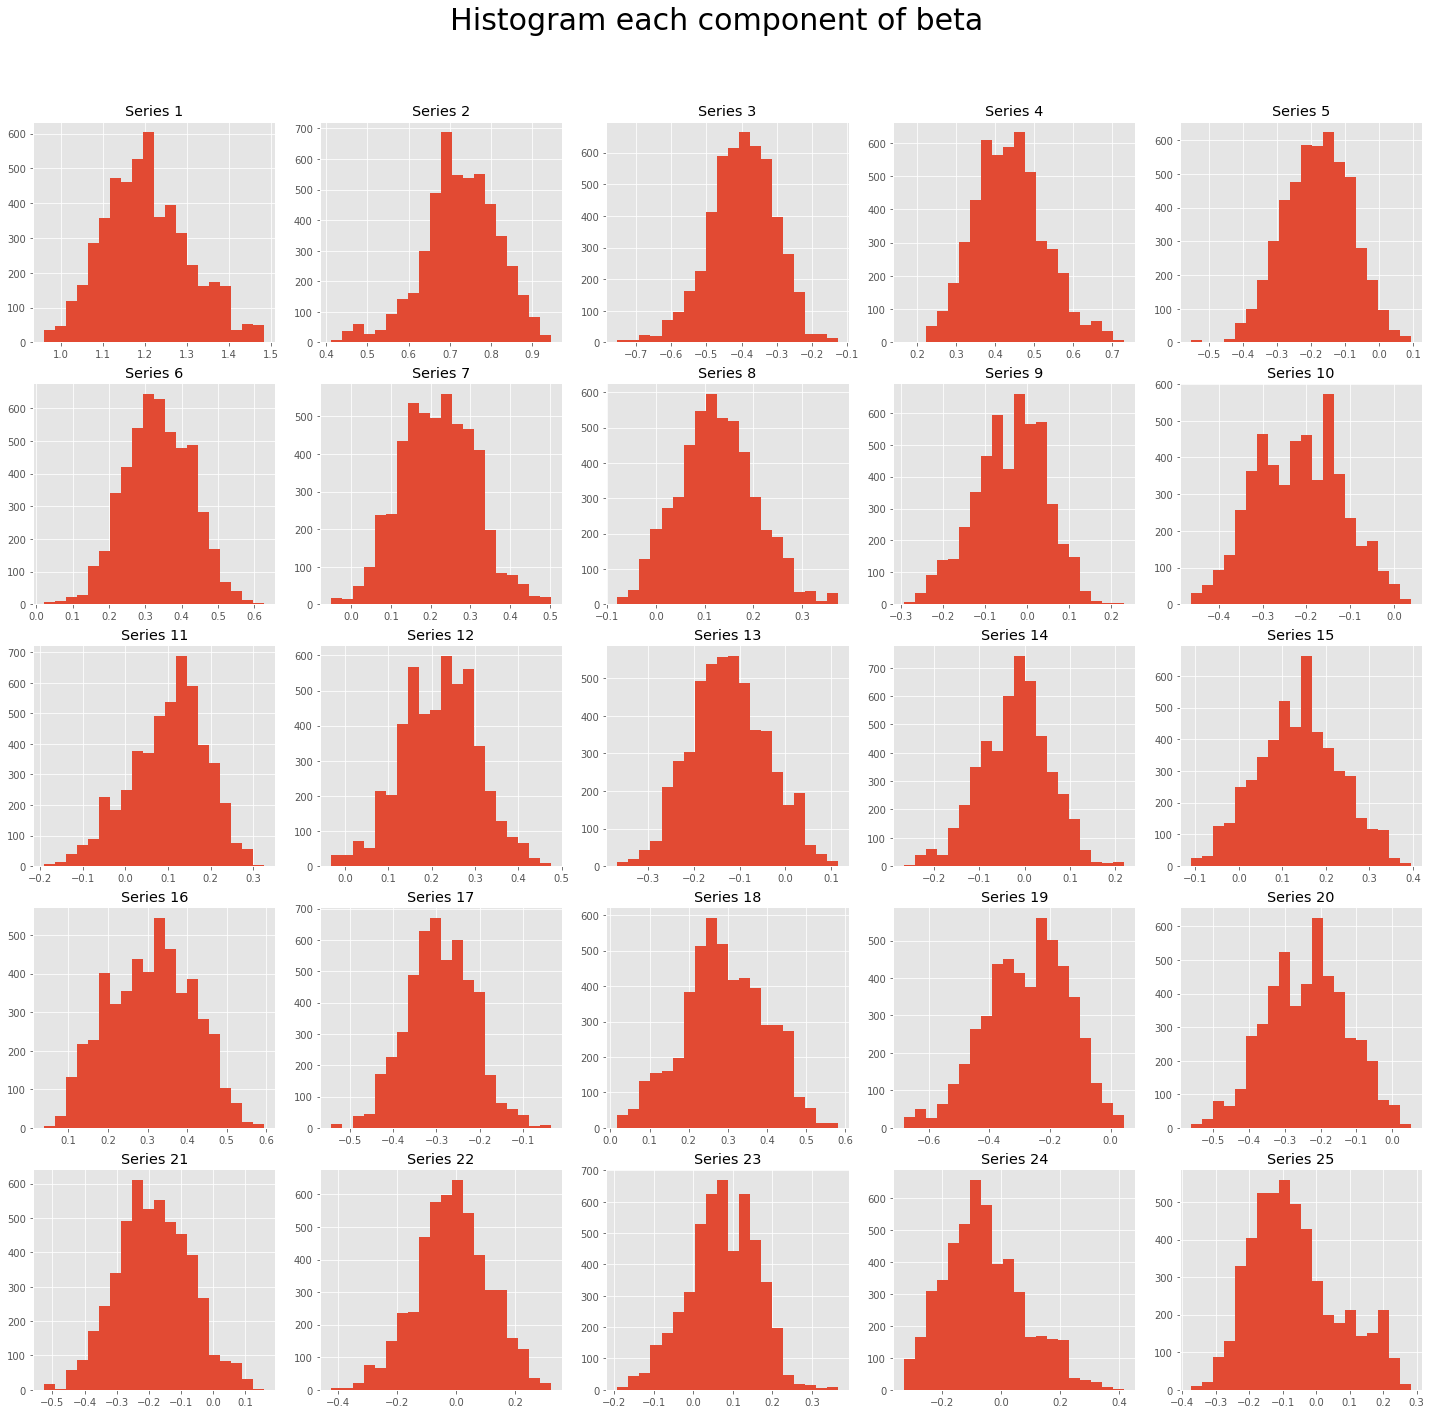

In [48]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    ax[i].hist(mcmc_robust['beta'][:, i], bins = 20)
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('Histogram each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

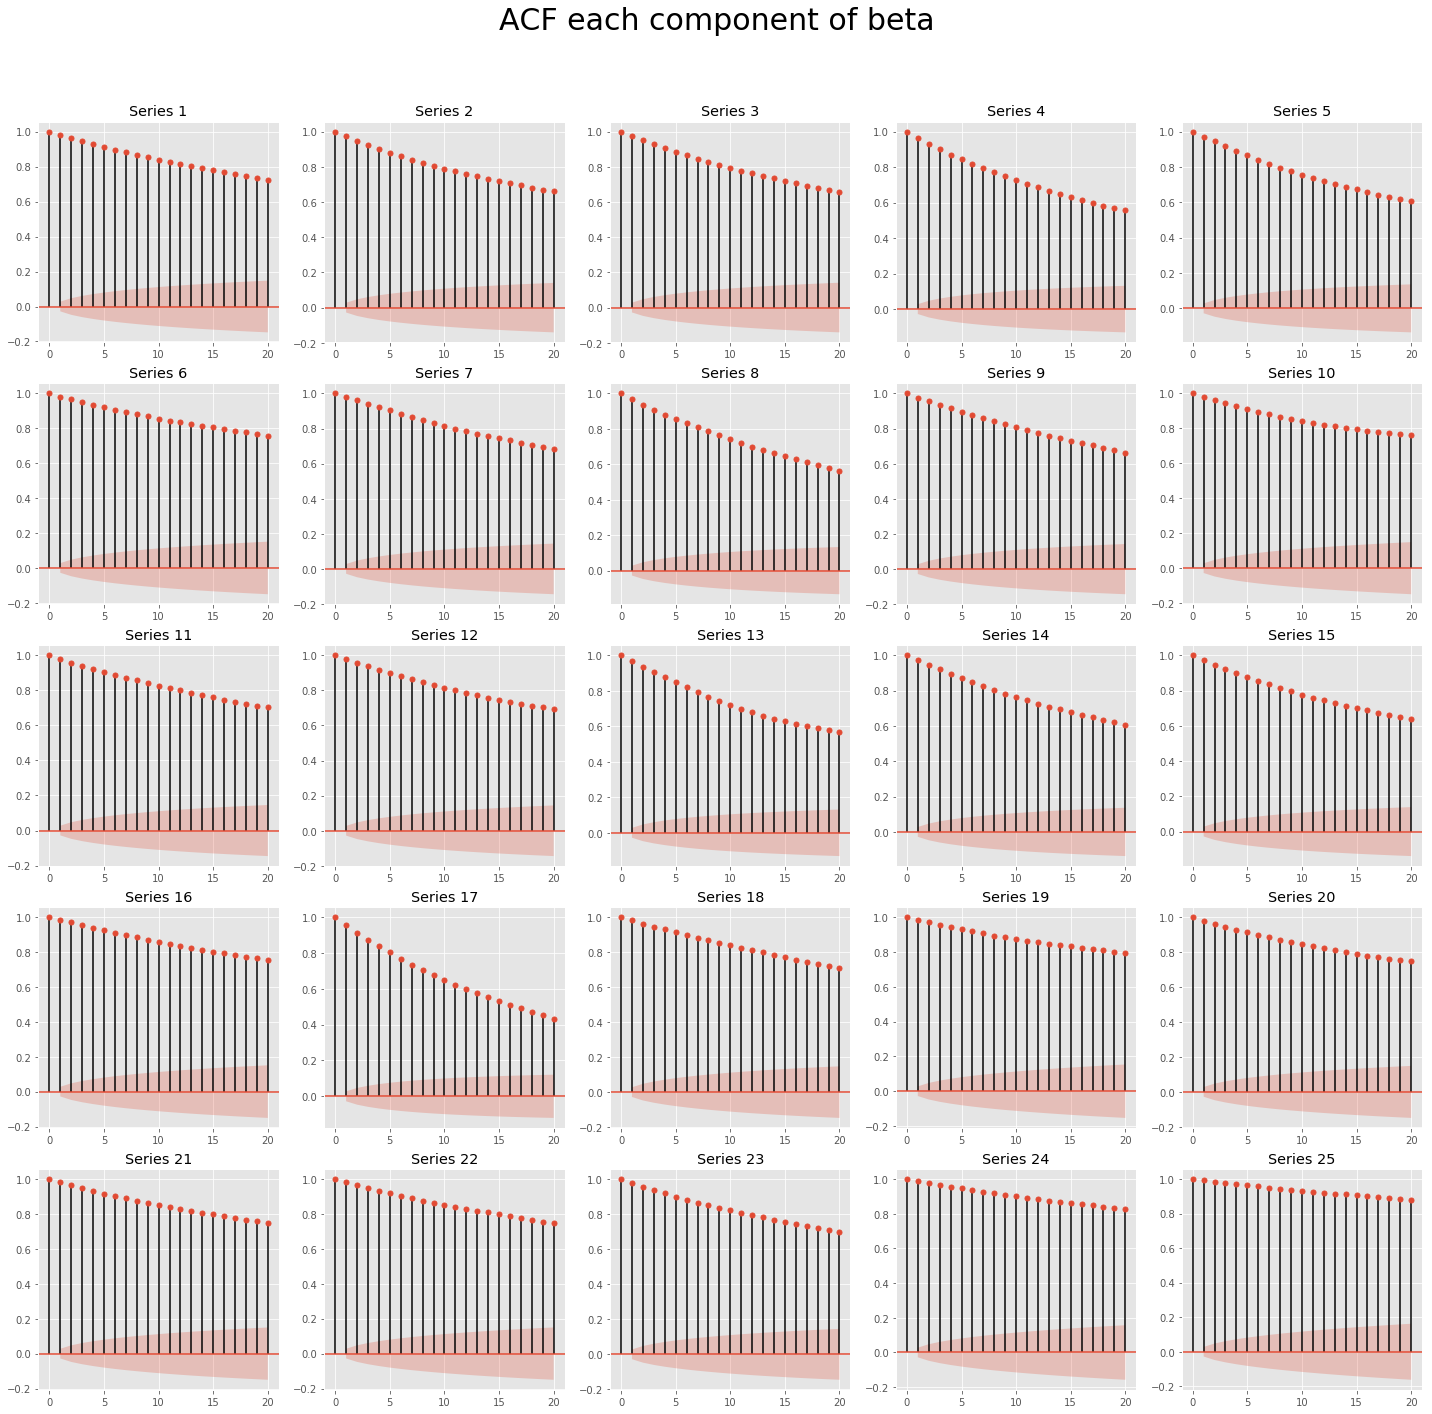

In [49]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    plot_acf(mcmc_robust['beta'][:, i], lags = 20, ax = ax[i])
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('ACF each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [50]:
likelihood_hist = log_likelihood(X, Y, mcmc_robust['beta'][:, :-1].T)

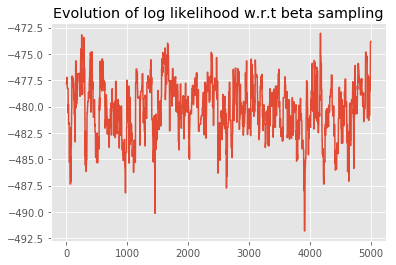

In [51]:
plt.plot(likelihood_hist)
plt.title('Evolution of log likelihood w.r.t beta sampling')
plt.show()

In [52]:
beta_opt = mcmc_robust['beta'][np.argmax(likelihood_hist), :-1]

In [53]:
Y_pred = np.where(sigmoid(X.dot(beta_opt)) > 0.5, 1, -1)

In [54]:
# Accuracy
len(np.where(Y == Y_pred)[0])*100/len(Y)

77.7

## 2. Hamiltonian Monte Carlo

In [55]:
def U(X, Y, beta):
    """
    U -- A function to evaluate minus the log of the density of the distribution to be sampled, 
    plus any constant - ie, the "potential energy".
    """
    return -log_likelihood(X, Y, beta)

In [56]:
def grad_U(X, Y, beta):
    return (X.T).dot(sigmoid(X.dot(beta) - Y))

In [57]:
def single_iteration(X, Y, U, grad_U, epsilon, L, current_q):
    """
    U -- A function to evaluate minus the log of the density of the distribution to be sampled
    grad_U -- A function to evaluate the gradient of U
    epsilon -- The stepsize to use for the leapfrog steps.
    L -- The number of leapfrog steps to do to propose a new state
    current_q -- The current state (position variables only)
    """
    q = current_q
    p = np.random.randn(len(q))  # independent standard normal variates
    current_p = p
    
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(X, Y, q) / 2

    # Alternate full steps for position and momentum    
    for i in range(L):
        # Make a full step for the position
        q = q + epsilon * p
        # Make a full step for the momentum, except at end of trajectory
        if i == (L - 1):
            p = p - epsilon * grad_U(X, Y, q)
            
    # Make a half step for momentum at the end.
    p = p - epsilon * grad_U(X, Y, q) / 2
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p

    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(X, Y, current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(X, Y, q)
    proposed_K = np.sum(p**2) / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position

    if np.squeeze(np.random.rand(1)) < np.exp(current_U - proposed_U + current_K - proposed_K):
        res = q
    else: 
        res = current_q
    return res

In [58]:
def HMC(X, Y, U, grad_U, epsilon, L, current_q, iterations):
    p = len(current_q)
    beta = np.zeros((iterations, p))
    for i in range(iterations):
        beta[i] = single_iteration(X, Y, U, grad_U, epsilon, L, current_q)
    return beta

In [59]:
beta_HMC = HMC(X, Y, U, grad_U, 0.000002, 20, beta_init[:-1], 10000)

In [60]:
beta_HMC.shape

(10000, 25)

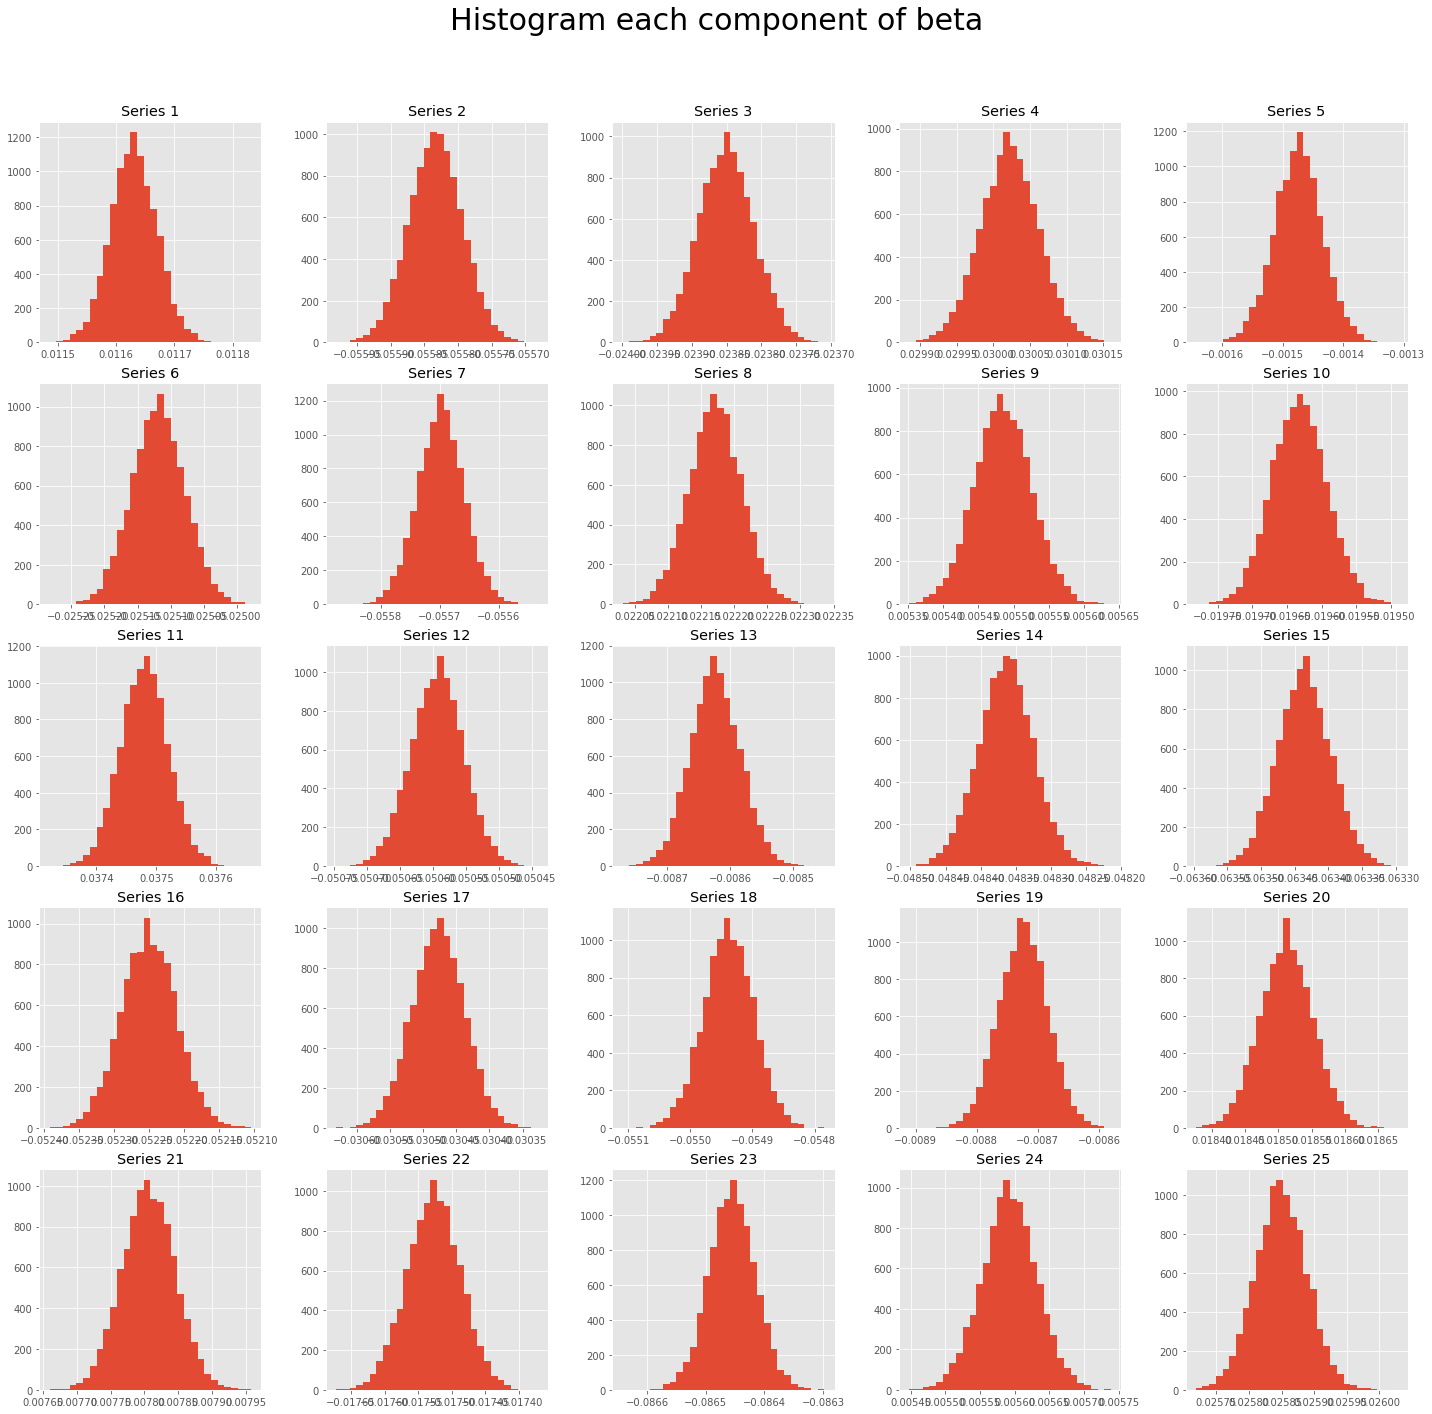

In [61]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    ax[i].hist(beta_HMC[:, i], bins = 30)
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('Histogram each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

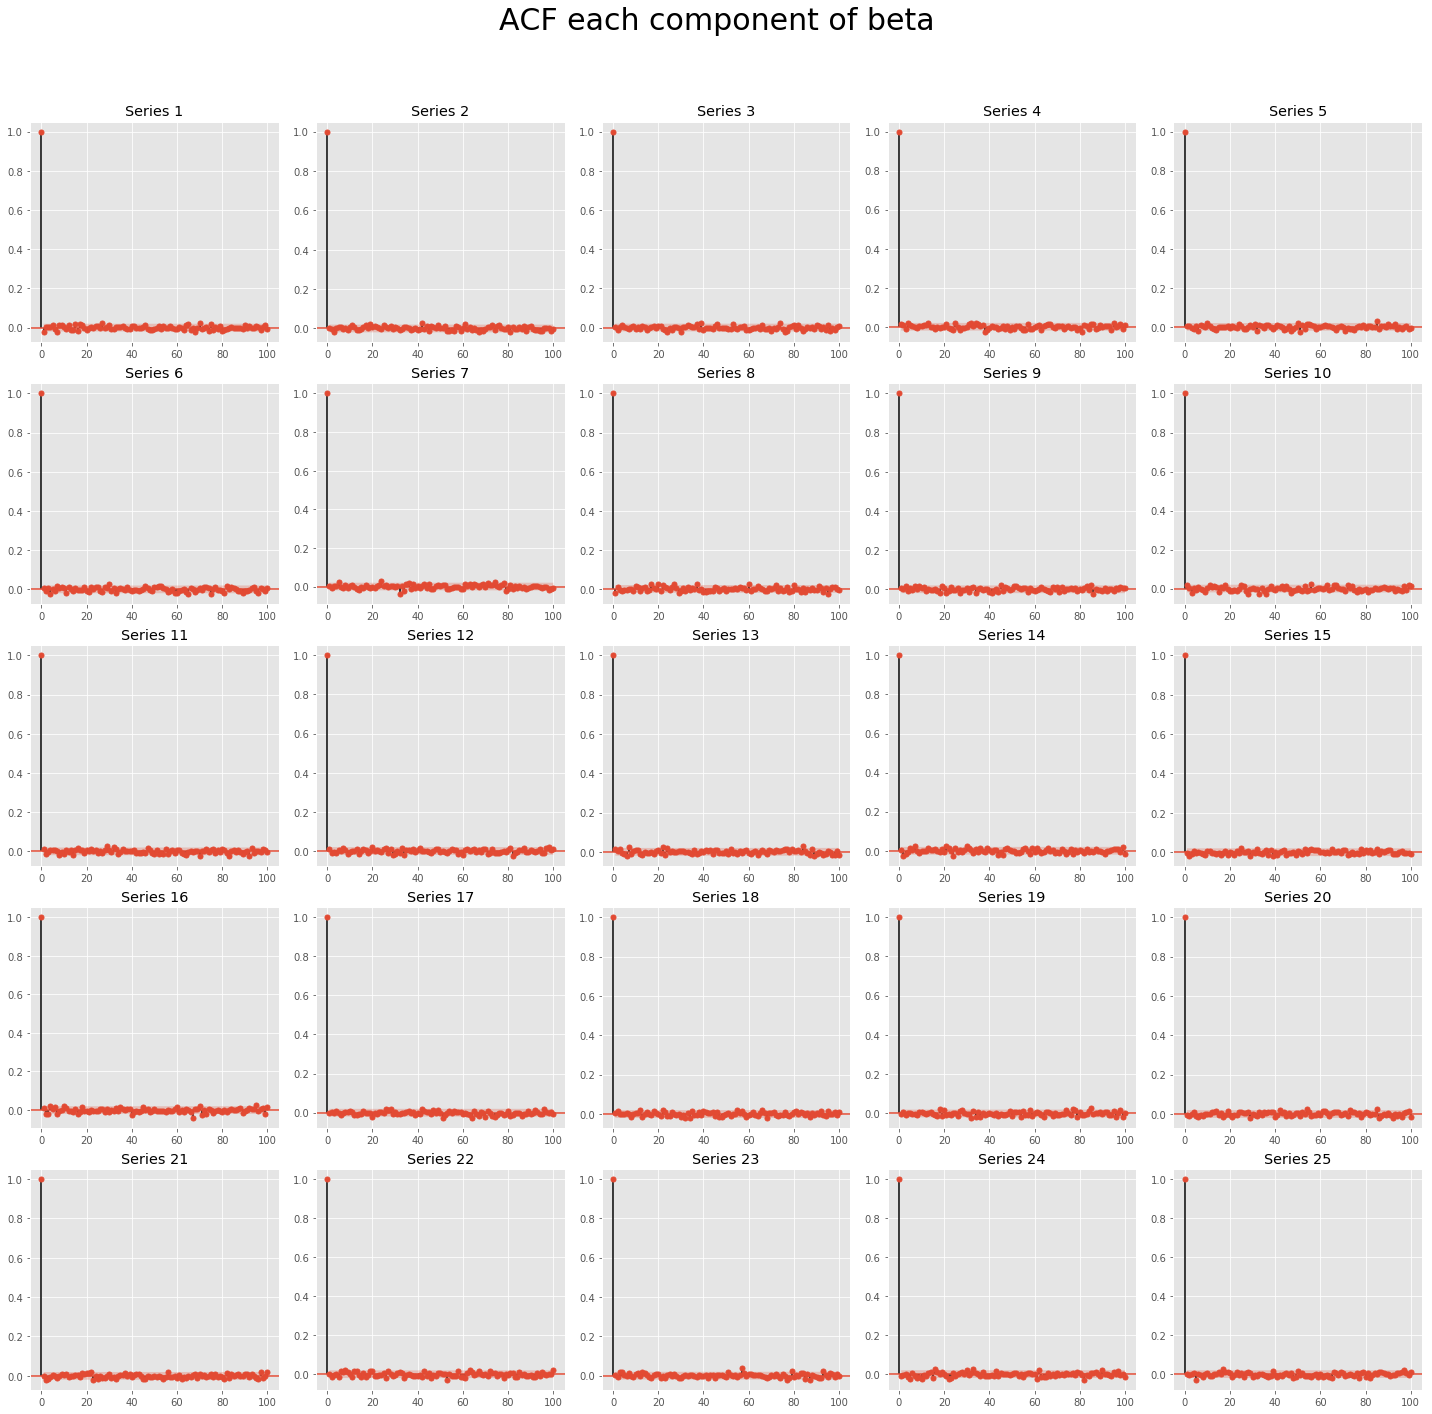

In [76]:
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
ax = ax.ravel()
for i in range(25):
    plot_acf(beta_HMC[:, i], lags = 100, ax = ax[i])
    ax[i].set_title('Series {}'.format(i + 1))
fig.suptitle('ACF each component of beta', size = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [77]:
likelihood_hist = log_likelihood(X, Y, beta_HMC.T)

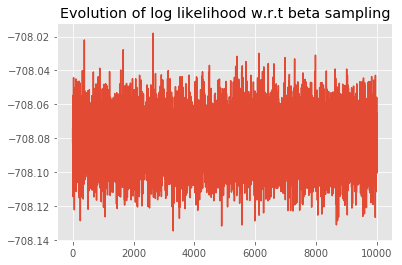

In [78]:
plt.plot(likelihood_hist)
plt.title('Evolution of log likelihood w.r.t beta sampling')
plt.savefig('LLH3.png')
plt.show()

In [65]:
beta_opt = beta_HMC[np.argmax(likelihood_hist)]

In [66]:
Y_pred = np.where(sigmoid(X.dot(beta_opt)) > 0.5, 1, -1)

In [67]:
# Accuracy
len(np.where(Y == Y_pred)[0])*100/len(Y)

46.0